In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import os
from joblib import dump, load
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
from SHG import SHG
from utils import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn_extra.cluster import KMedoids
from AE import CONV_AE

In [3]:
""" PATHS """

# ALL SKELETONS
AE_ALL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/AE_latent_spaces/all/"
SHG_ALL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_all/"

# OBSERVATIONS WITH ONLY FULL SKELETONS
AE_FULL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/AE_latent_spaces/full/"
SHG_FULL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_full_skeleton/"

In [4]:
""" DATASET AND DATALOADER """

class dataset(Dataset):
    def __init__(self, PATH):
        self.FULL_PATH = PATH
        self.listdir = os.listdir(self.FULL_PATH)

    def __len__(self):
        return len(self.listdir)

    def __getitem__(self, i):
        path = self.FULL_PATH + self.listdir[i]
        data = np.load(path)
        return data

AE_ALL_DATASET = dataset(AE_ALL_DATA_PATH)
AE_ALL_DATALOADER = DataLoader(AE_ALL_DATASET)

SHG_ALL_DATASET = dataset(SHG_ALL_DATA_PATH)
SHG_ALL_DATALOADER = DataLoader(SHG_ALL_DATASET)

AE_FULL_DATASET = dataset(AE_FULL_DATA_PATH)
AE_FULL_DATALOADER = DataLoader(AE_FULL_DATASET)

SHG_FULL_DATASET = dataset(SHG_FULL_DATA_PATH)
SHG_FULL_DATALOADER = DataLoader(SHG_FULL_DATASET)

In [8]:
""" CREATING DATASETS FOR PCA - ALL"""

N = 10000 # Number of observations
SHG_all_latent_space = []
AE_all_latent_space = []

# SHG
for i, x in enumerate(tqdm(SHG_ALL_DATALOADER, total = N, desc = "SHG", leave = False)):
    SHG_all_latent_space.append(x.data.numpy())

    if (i == N - 1):
        break
SHG_all_latent_space = np.array(SHG_all_latent_space).reshape((N, -1))

# AE
for i, x in enumerate(tqdm(AE_ALL_DATALOADER, total = N, desc = "AE", leave = False)):
    AE_all_latent_space.append(x.data.numpy())

    if (i == N - 1):
        break
AE_all_latent_space = np.array(AE_all_latent_space).reshape((N, -1))

SHG needs 514 principal components to reach 95% explained variance ratio
AE needs 261 principal components to reach 95% explained variance ratio


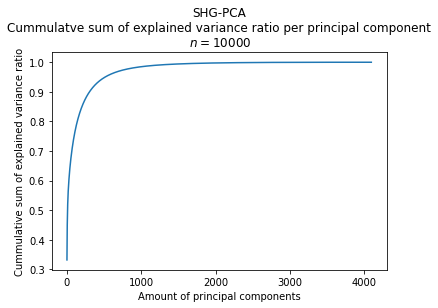

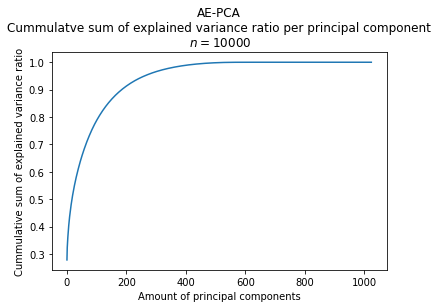

In [19]:
""" PCA - ALL """

# Fitting PCA's
SHG_all_pca = PCA(n_components = SHG_all_latent_space.shape[1]).fit(SHG_all_latent_space)
AE_all_pca = PCA(n_components = AE_all_latent_space.shape[1]).fit(AE_all_latent_space)

# Finding cum. sums of variances
SHG_all_cum_sum = np.cumsum(SHG_all_pca.explained_variance_ratio_)
AE_all_cum_sum = np.cumsum(AE_all_pca.explained_variance_ratio_)

# Index when cum. sums > 0.95
SHG_ALL_THRESHOLD = np.argmax(SHG_all_cum_sum > 0.95)
AE_ALL_THRESHOLD = np.argmax(AE_all_cum_sum > 0.95)

print("SHG needs {} principal components to reach 95% explained variance ratio".format(SHG_ALL_THRESHOLD))
print("AE needs {} principal components to reach 95% explained variance ratio".format(AE_ALL_THRESHOLD))

# Plotting variances
plt.figure()
plt.plot(SHG_all_cum_sum)
plt.title("SHG-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(SHG_all_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.show()

plt.figure()
plt.plot(AE_all_cum_sum)
plt.title("AE-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(AE_all_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.show()

In [6]:
""" CREATING DATASETS FOR PCA - FULL"""
SHG_full_latent_space = []
AE_full_latent_space = []

# SHG
for i, x in enumerate(tqdm(SHG_FULL_DATALOADER, desc = "SHG", leave = False)):
    SHG_full_latent_space.append(x.data.numpy())

SHG_full_latent_space = np.array(SHG_full_latent_space).reshape((len(SHG_FULL_DATALOADER), -1))

# AE
for i, x in enumerate(tqdm(AE_FULL_DATALOADER, desc = "AE", leave = False)):
    AE_full_latent_space.append(x.data.numpy())

AE_full_latent_space = np.array(AE_full_latent_space).reshape((len(SHG_FULL_DATALOADER), -1))

SHG needs 402 principal components to reach 95% explained variance ratio
AE needs 180 principal components to reach 95% explained variance ratio


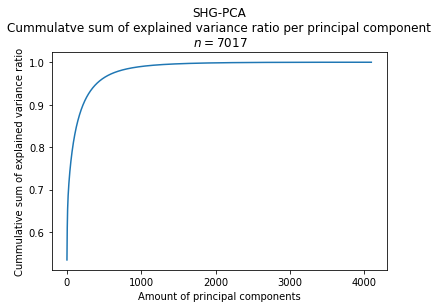

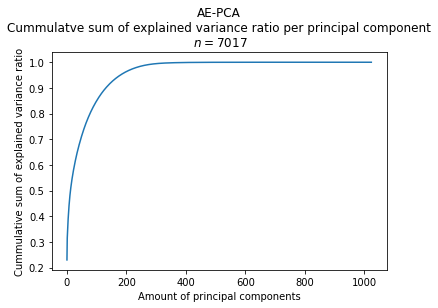

In [9]:
""" PCA - FULL """

# Fitting PCA's
SHG_full_pca = PCA(n_components = SHG_full_latent_space.shape[1]).fit(SHG_full_latent_space)
AE_full_pca = PCA(n_components = AE_full_latent_space.shape[1]).fit(AE_full_latent_space)

# Finding cum. sums of variances
SHG_full_cum_sum = np.cumsum(SHG_full_pca.explained_variance_ratio_)
AE_full_cum_sum = np.cumsum(AE_full_pca.explained_variance_ratio_)

# Index when cum. sums > 0.95
SHG_FULL_THRESHOLD = np.argmax(SHG_full_cum_sum > 0.95)
AE_FULL_THRESHOLD = np.argmax(AE_full_cum_sum > 0.95)

print("SHG needs {} principal components to reach 95% explained variance ratio".format(SHG_FULL_THRESHOLD))
print("AE needs {} principal components to reach 95% explained variance ratio".format(AE_FULL_THRESHOLD))

# Plotting variances
plt.figure()
plt.plot(SHG_full_cum_sum)
plt.title("SHG-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(SHG_full_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.show()

plt.figure()
plt.plot(AE_full_cum_sum)
plt.title("AE-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(AE_full_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.show()